# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

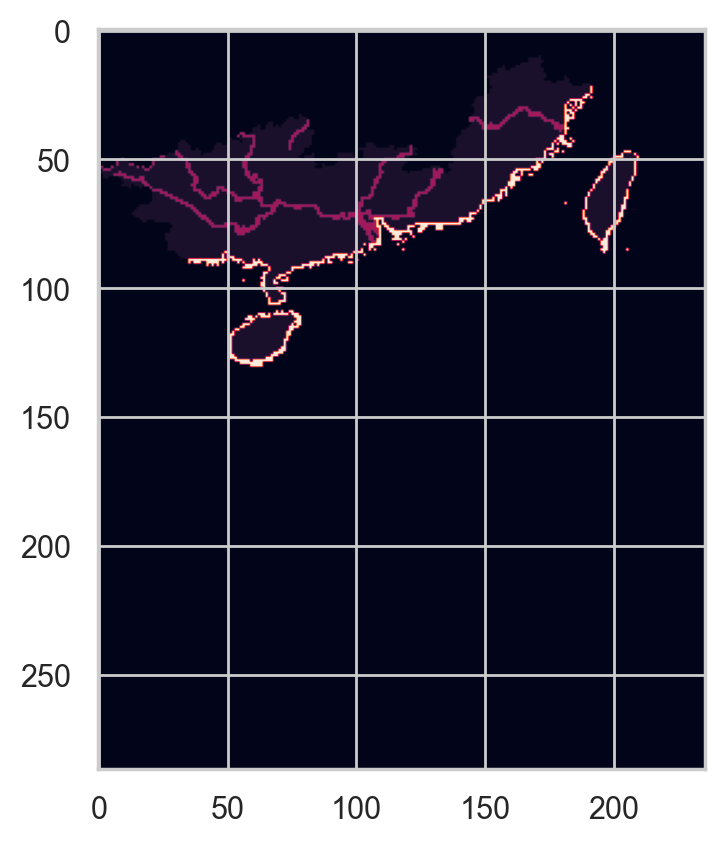

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

import rasterio

with rasterio.open(cfg.db.lim_h) as dataset:
    arr = dataset.read(1)
    plt.imshow(arr)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [5]:
# 从这个路径加载模型
from src.core import Model

model = Model(parameters=cfg)
model.params.save_plots = False

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

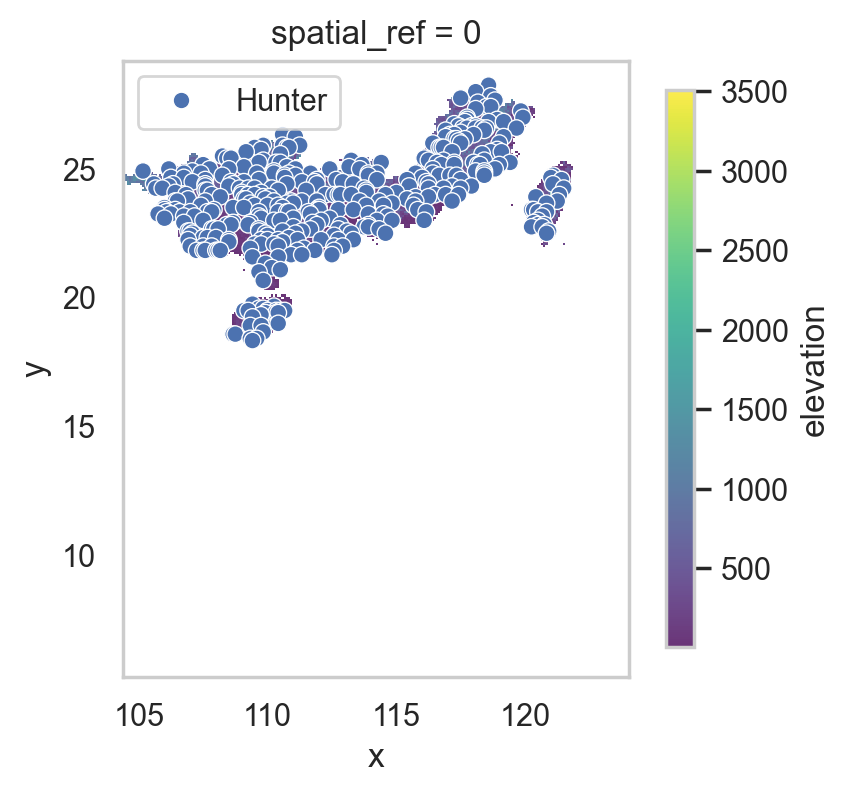

In [6]:
model.nature.plot.show("elevation")

<Axes: xlabel='size', ylabel='Count'>

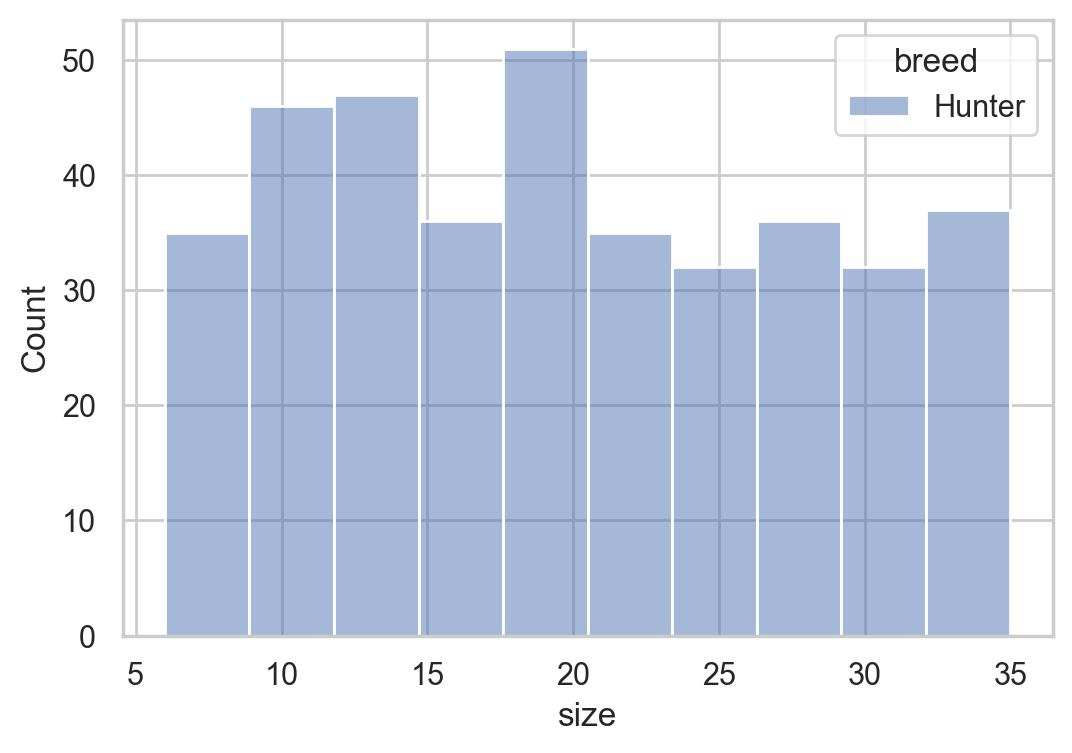

In [7]:
model.actors.plot.hist("size")

农民可以停留的可耕种土地有3074，分布如下图：


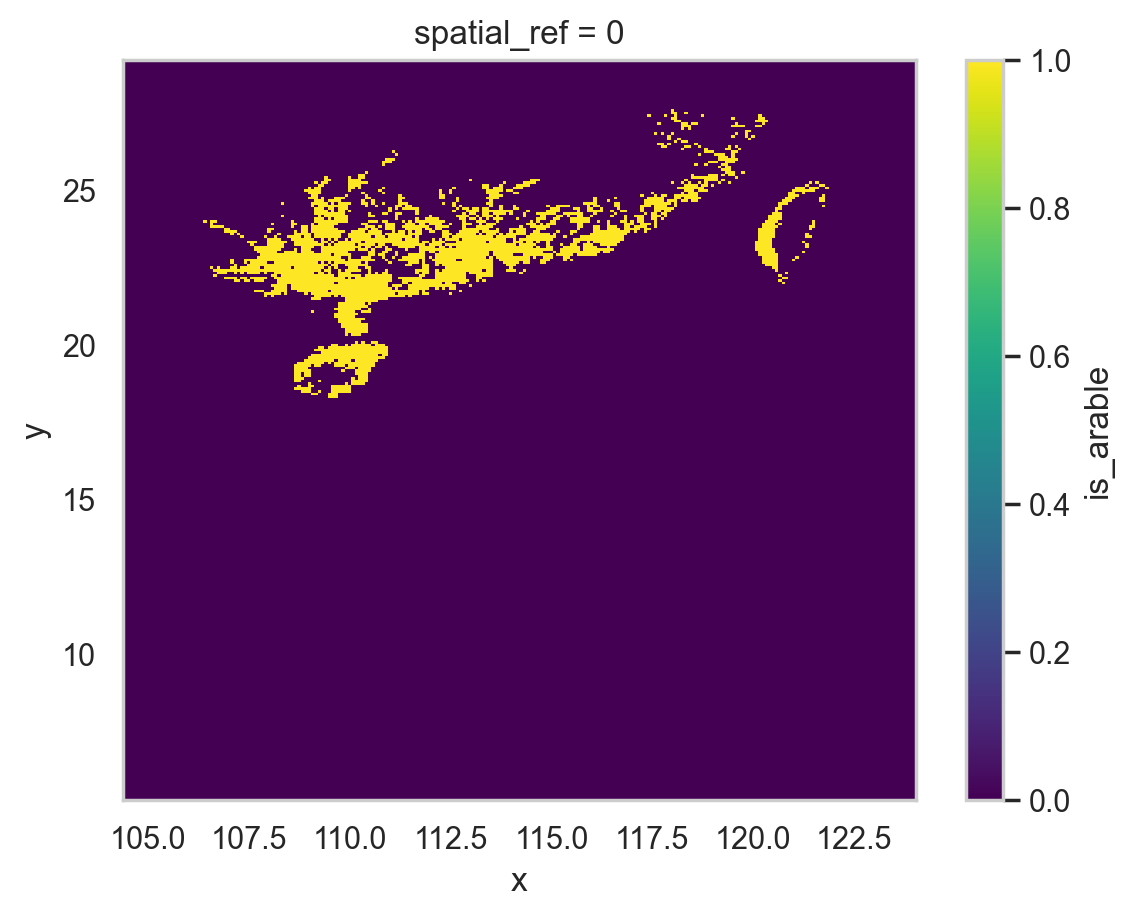

In [8]:
arable_land = model.nature.get_xarray("is_arable")
print(f"农民可以停留的可耕种土地有{arable_land.to_numpy().sum()}，分布如下图：")
arable_land.plot()

水稻农民可以停留的可耕种土地有924，分布如下图：


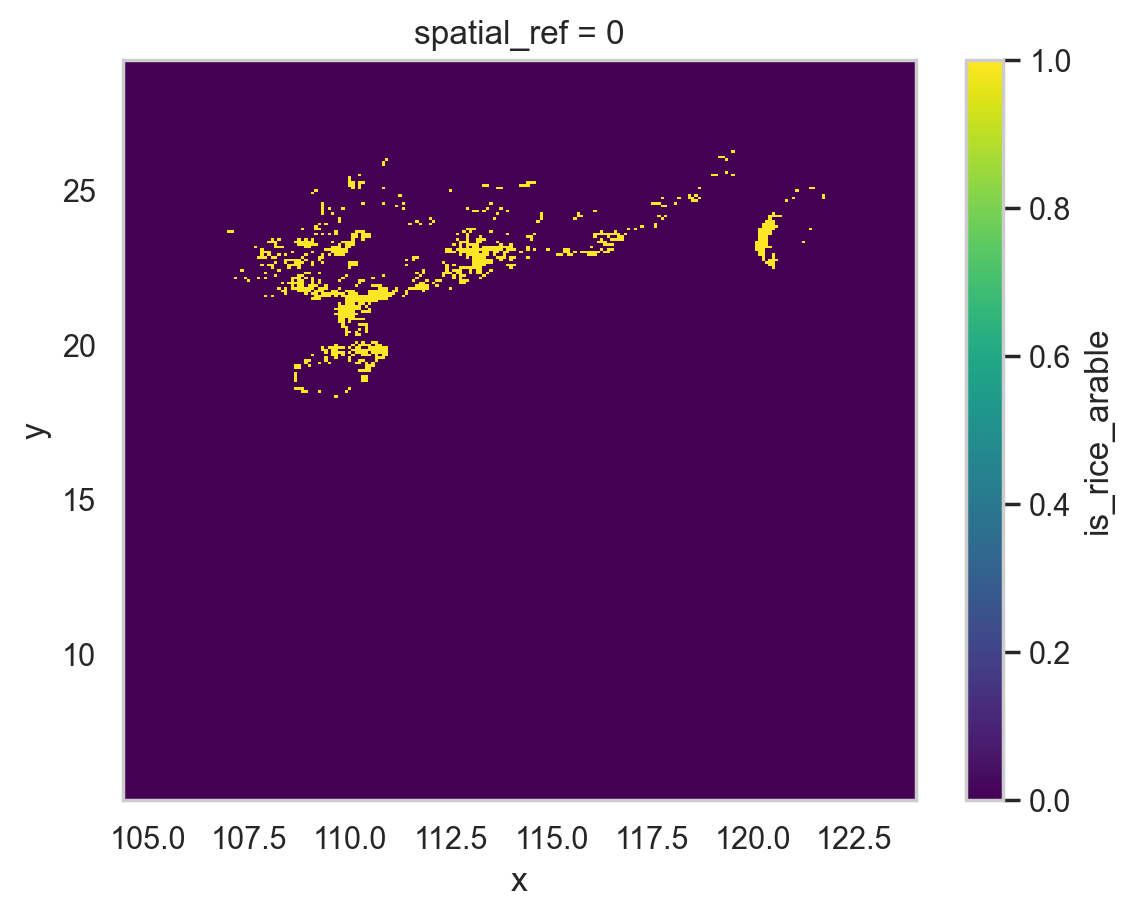

In [9]:
rice_arable = model.nature.patchmodule.get_xarray("is_rice_arable")
print(f"水稻农民可以停留的可耕种土地有{rice_arable.to_numpy().sum()}，分布如下图：")
rice_arable.plot()

增加了初始的 Hunters，随机生成在地图上

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

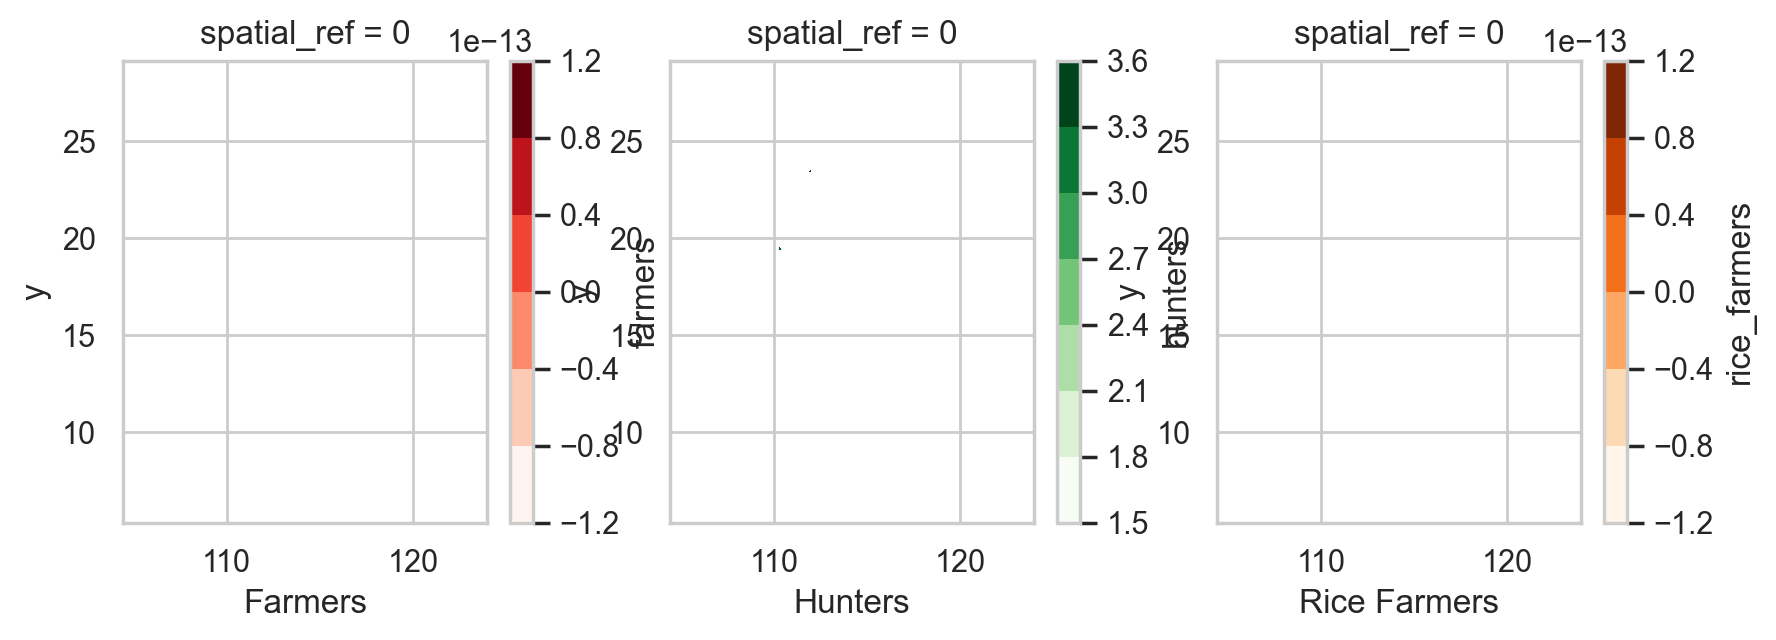

In [10]:
model.plot.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

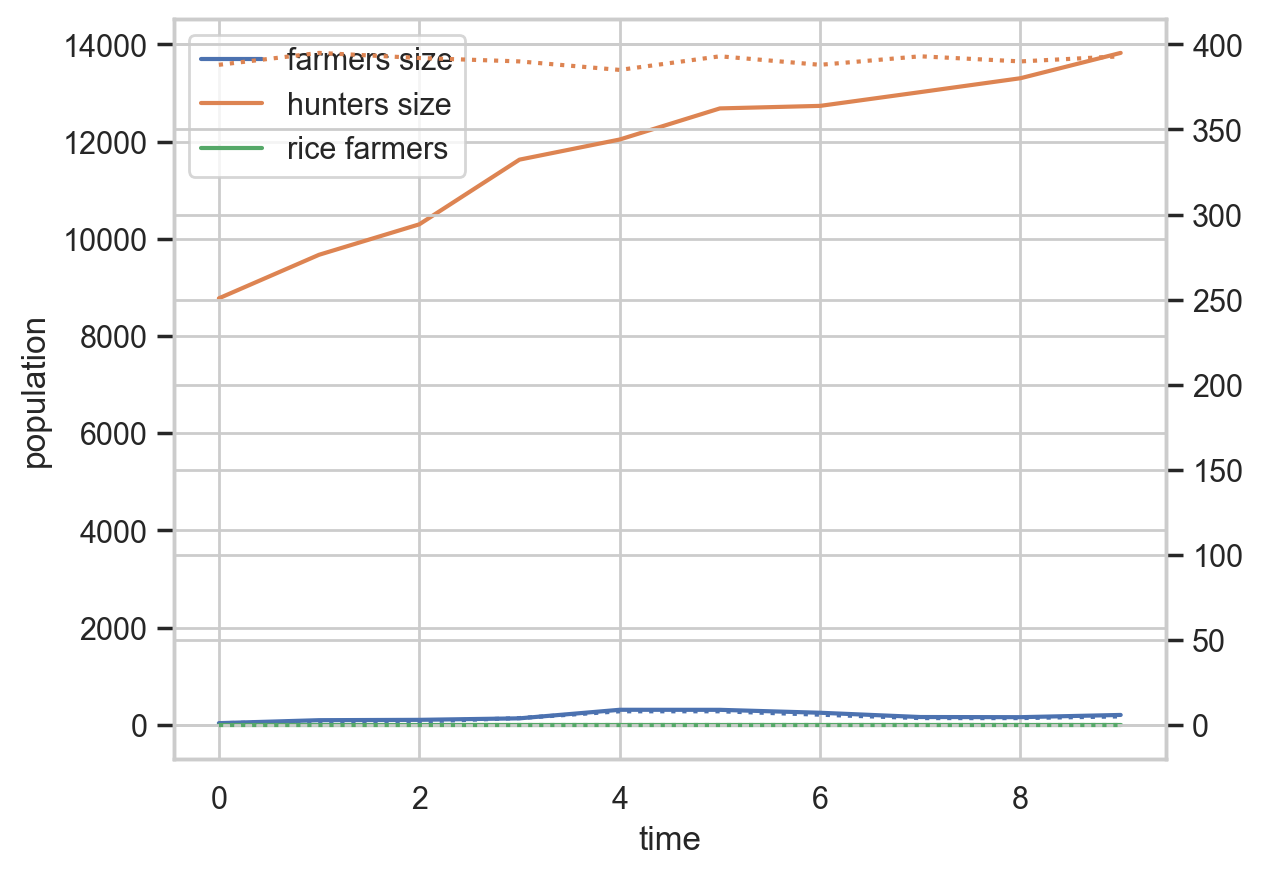

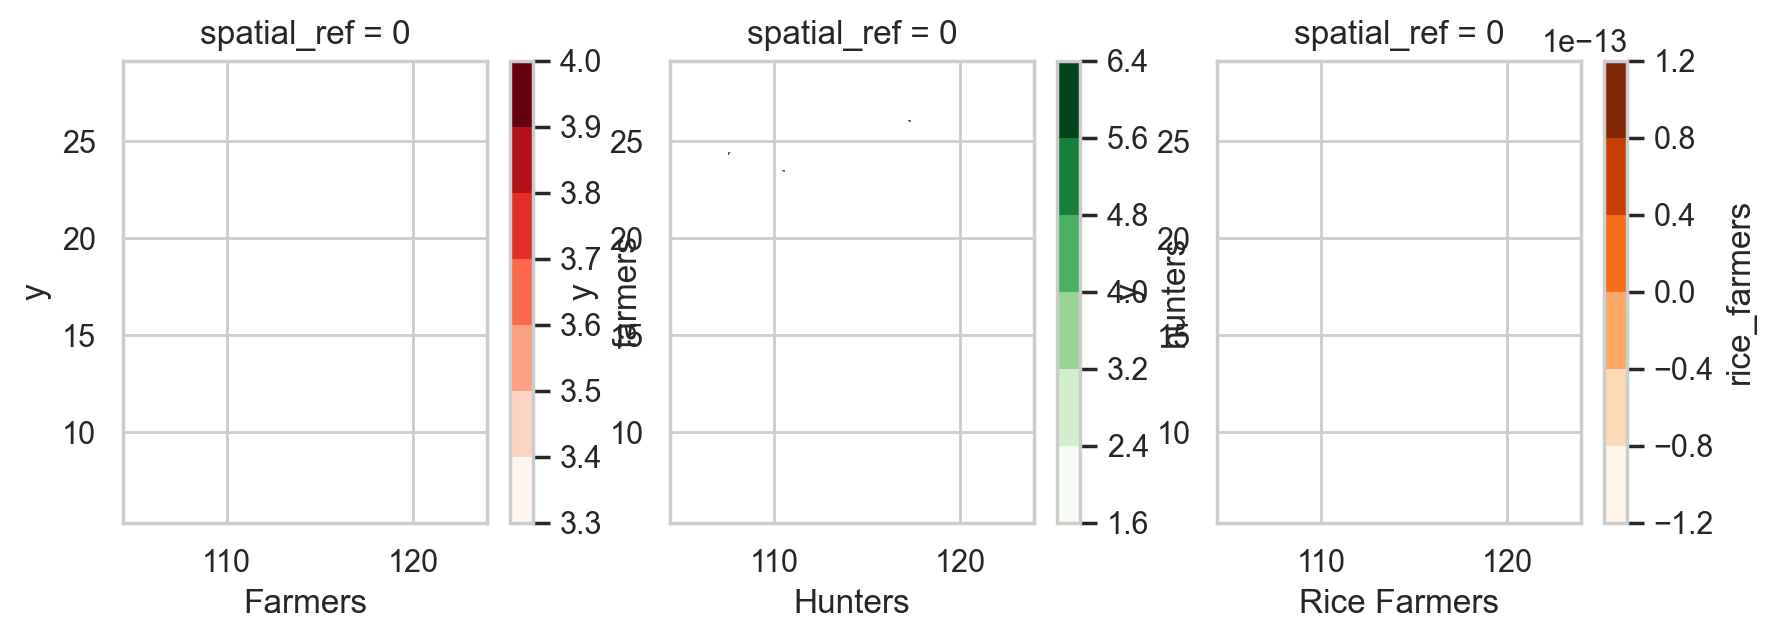

In [11]:
model.run_model(steps=200)

展示主体的信息

<Axes: xlabel='size', ylabel='Count'>

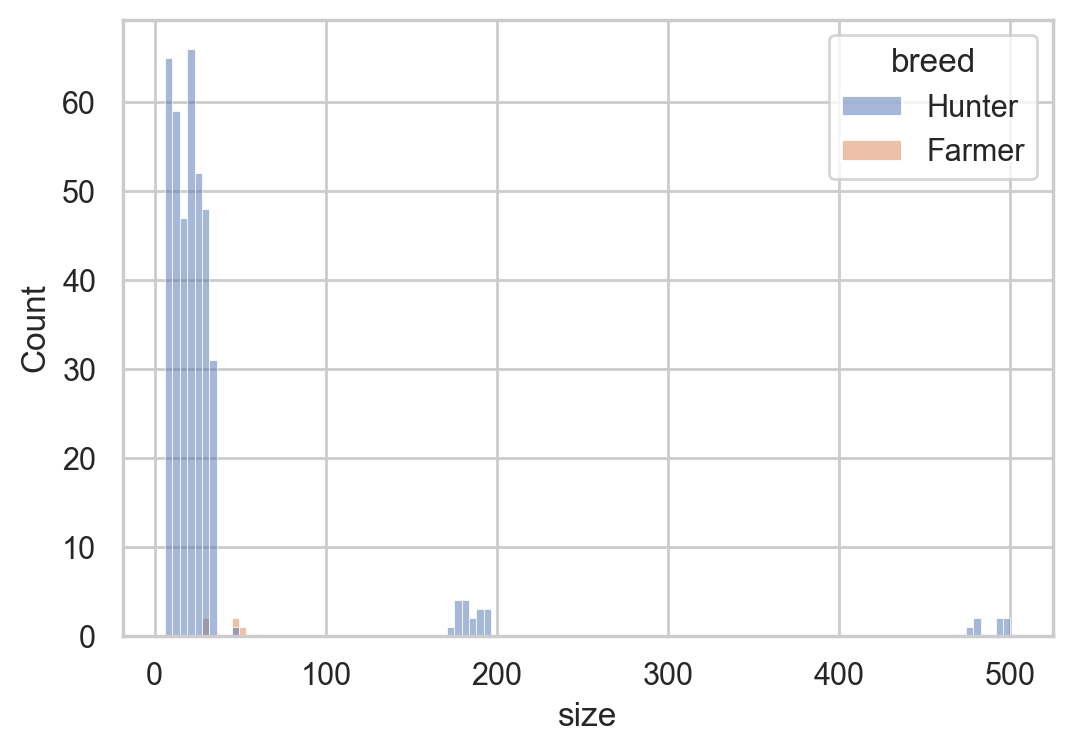

In [12]:
model.actors.plot.hist("size")

In [13]:
agent = model.actors.random.choice()
agent.report()

unique_id         452
breed          Hunter
size             27.0
position     (60, 57)
dtype: object

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

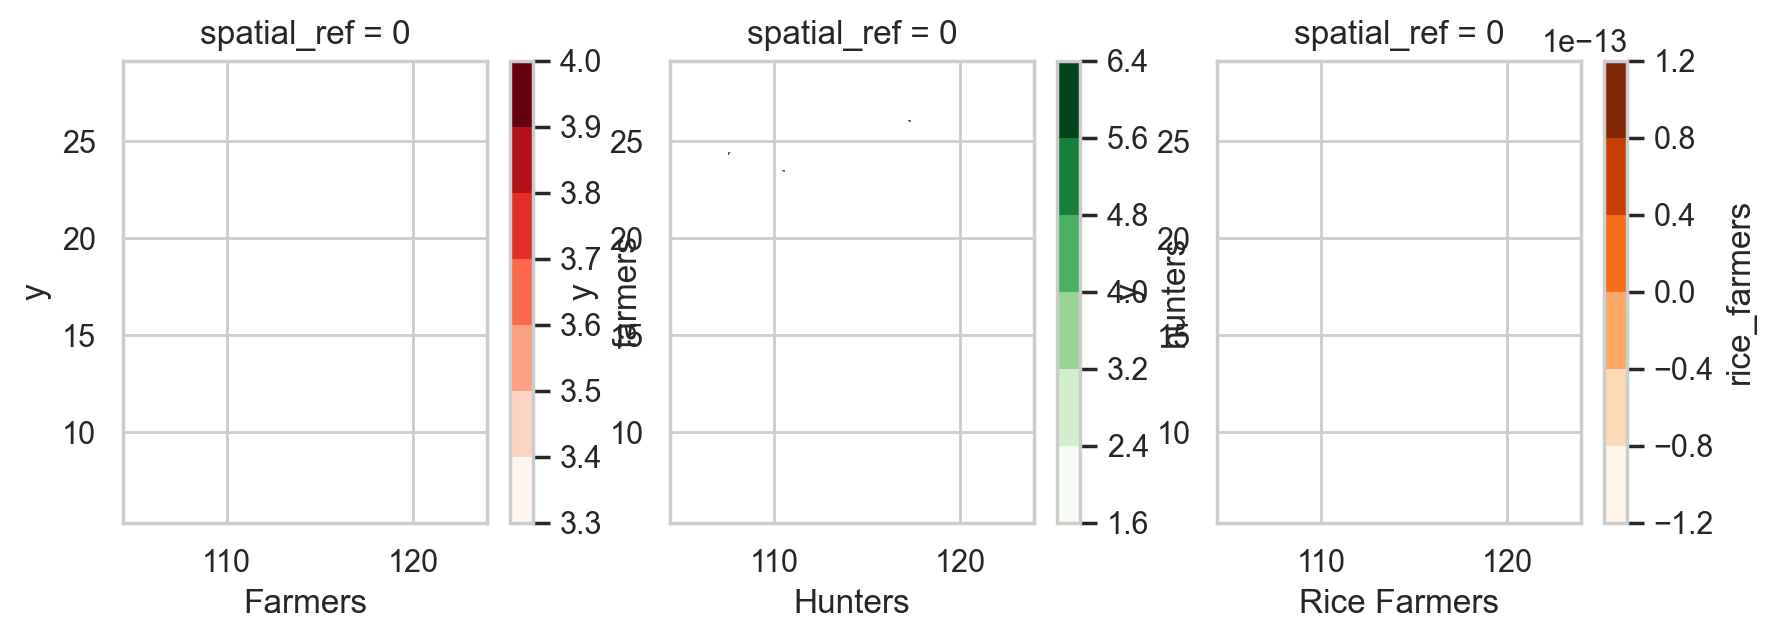

In [14]:
model.plot.heatmap()

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

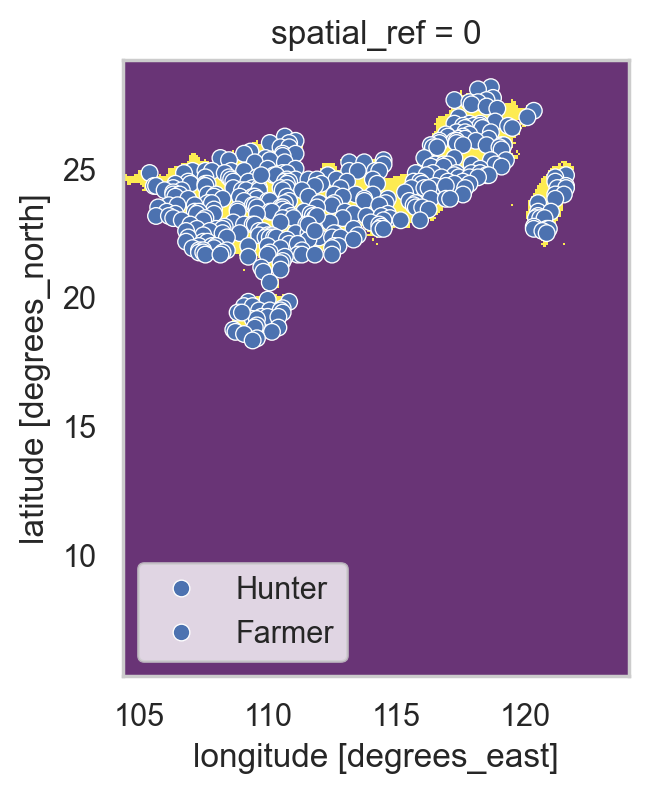

In [15]:
model.nature.plot.show()

In [16]:
model.hunters
model.farmers

<ActorsList: (393)Hunter>

<ActorsList: (5)Farmer>

(<Axes: xlabel='Population'>, <Axes: xlabel='Groups'>)

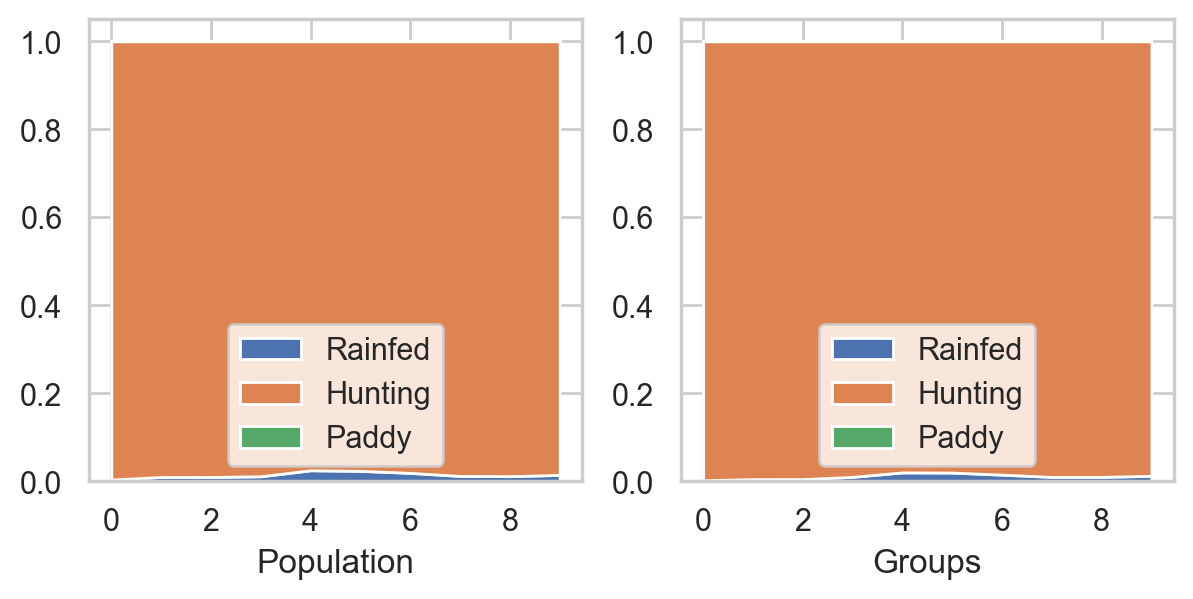

In [17]:
model.plot.stack_dynamic()

<Axes: xlabel='size', ylabel='Count'>

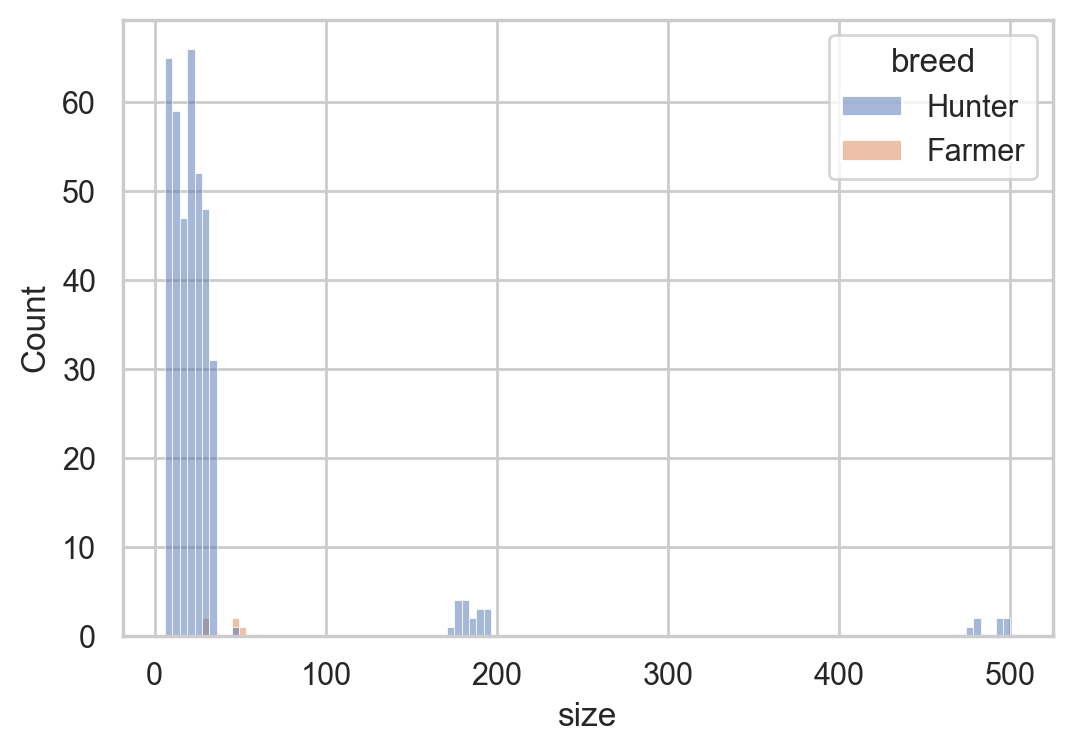

In [18]:
model.actors.plot.hist("size")

In [19]:
from src.core import MyExperiment

exp = MyExperiment(Model)
exp.batch_run(
    cfg=cfg, repeats=10, parallels=5, overrides={"farmer.growth_rate": [0.1, 0.2, 0.3]}
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='tick', ylabel='num_farmers'>

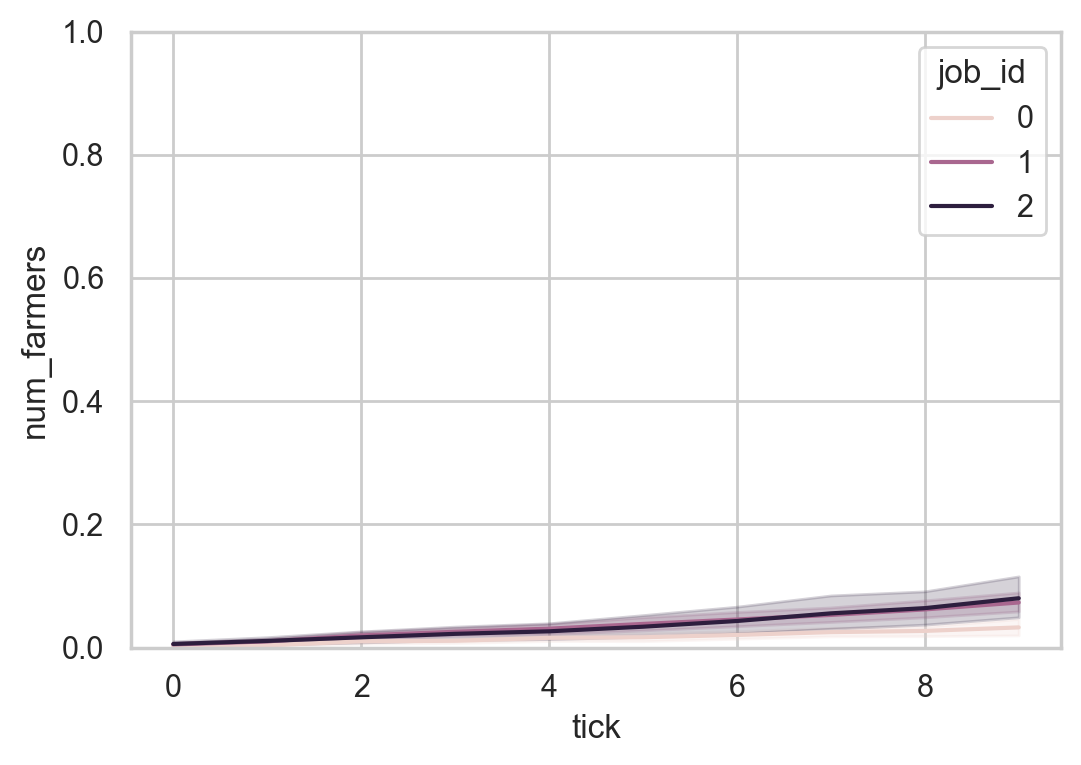

In [20]:
exp.plot_agg_dynamic("farmers", "num")

In [21]:
data = exp.get_model_vars_dataframe()
data.head()

,job_id,repeat_id,tick,len_farmers,len_hunters,len_rice,num_farmers,num_hunters,num_rice,len_farmers_n,len_hunters_n,len_rice_n,num_farmers_n,num_hunters_n,num_rice_n
0,0,1,0,0.002506,0.997494,0.0,0.005926,0.994074,0.0,1,398,0,50.0,8388.0,0.0
1,0,1,1,0.007576,0.992424,0.0,0.013751,0.986249,0.0,3,393,0,129.0,9252.0,0.0
2,0,1,2,0.012500,0.987500,0.0,0.021637,0.978363,0.0,5,395,0,248.0,11214.0,0.0
3,0,1,3,0.010309,0.989691,0.0,0.015481,0.984519,0.0,4,384,0,190.0,12083.0,0.0
4,0,1,4,0.005195,0.994805,0.0,0.009603,0.990397,0.0,2,383,0,129.0,13305.0,0.0


In [28]:
ser = model.datacollector.get_model_vars_dataframe()["num_hunters_n"]
ser.head()

0     8776.0
1     9672.0
2    10298.0
3    11629.0
4    12043.0
Name: num_hunters_n, dtype: float64

In [31]:
ser.pct_change()

0         NaN
1    0.102097
2    0.064723
3    0.129248
4    0.035601
5    0.053143
6    0.004100
7    0.022222
8    0.021970
9    0.039161
Name: num_hunters_n, dtype: float64

In [22]:
exp.summary()

,bkp_farmer,bkp_rice,bkp_hunters,job_id,repeat_id,farmer.growth_rate
0,5,5,5,0,1,0.1
1,5,5,5,0,2,0.1
2,5,5,5,0,3,0.1
3,5,5,5,0,4,0.1
4,5,5,5,0,5,0.1
5,5,5,5,0,6,0.1
6,5,5,5,0,7,0.1
7,5,5,5,0,8,0.1
8,5,5,5,0,9,0.1
9,5,5,5,0,10,0.1


In [22]:
data.groupby(["job_id", "tick"])

In [23]:
model_data = model.datacollector.get_model_vars_dataframe()
detect_breakpoints(model_data["len_farmers"], n_bkps=1)

5

In [24]:
exp.summary()

,bkp_farmer,bkp_rice,bkp_hunters,job_id,repeat_id,farmer.growth_rate
0,5,5,5,0,1,0.1
1,5,5,5,0,2,0.1
2,5,5,5,0,3,0.1
3,5,5,5,0,4,0.1
4,5,5,5,0,5,0.1
5,5,5,5,0,6,0.1
6,5,5,5,0,7,0.1
7,5,5,5,0,8,0.1
8,5,5,5,0,9,0.1
9,5,5,5,0,10,0.1


In [25]:
df_long = exp.summary().melt(
    id_vars=["job_id", "repeat_id"],
    value_vars=["bkp_farmer", "bkp_hunters", "bkp_rice"],
    var_name="cate",
    value_name="bkp",
)
df_long

,job_id,repeat_id,cate,bkp
0,0,1,bkp_farmer,5
1,0,2,bkp_farmer,5
2,0,3,bkp_farmer,5
3,0,4,bkp_farmer,5
4,0,5,bkp_farmer,5
...,...,...,...,...
85,2,6,bkp_rice,5
86,2,7,bkp_rice,5
87,2,8,bkp_rice,5
88,2,9,bkp_rice,5


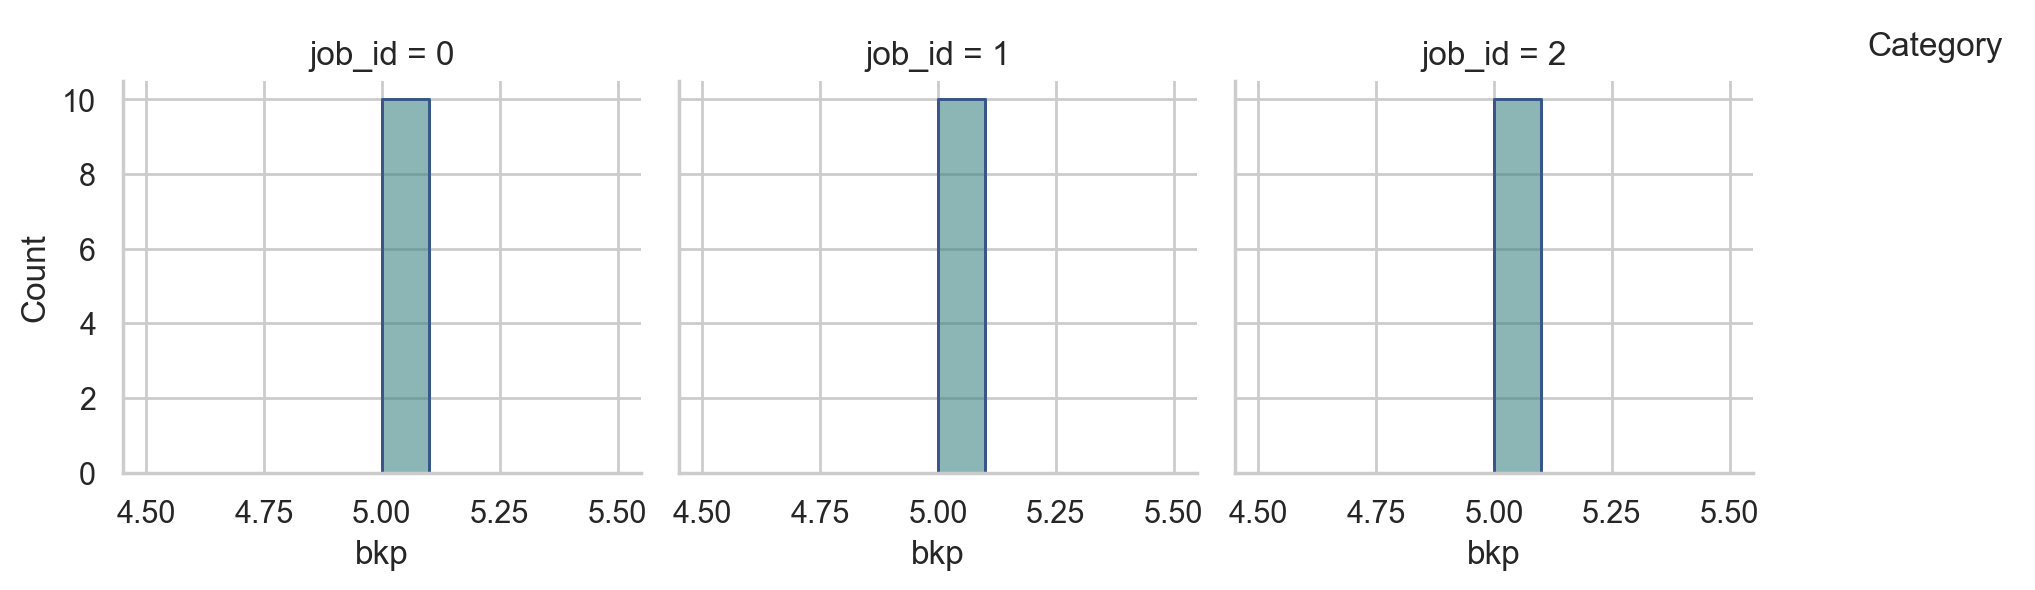

In [26]:
g = sns.FacetGrid(df_long, col="job_id", col_wrap=3, height=3)
g.map_dataframe(
    sns.histplot,
    x="bkp",
    hue="cate",
    bins=10,
    kde=True,
    element="step",
    palette="viridis",
)
g.add_legend(title="Category", loc="upper right", bbox_to_anchor=(1.05, 1))
plt.show()

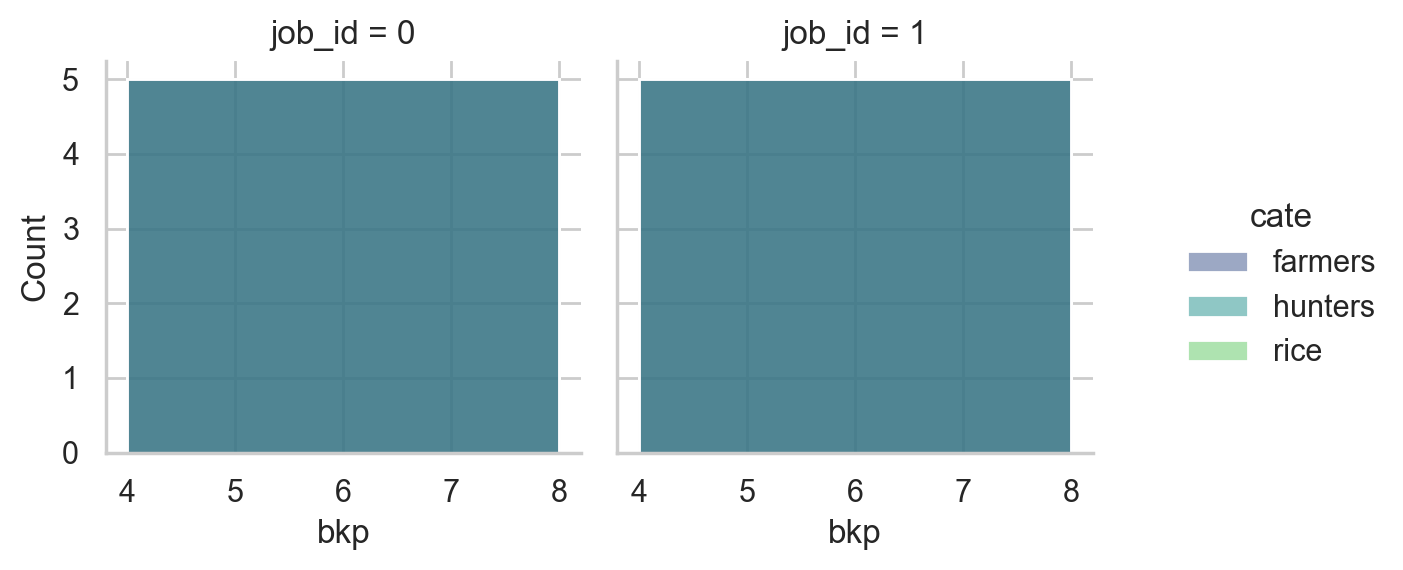

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 更新数据以确保有多样性
data = {
    "bkp_farmer": [5, 6, 5, 6, 5, 6, 5, 6, 5, 6],
    "bkp_rice": [4, 5, 4, 5, 4, 5, 4, 5, 4, 5],
    "bkp_hunters": [7, 8, 7, 8, 7, 8, 7, 8, 7, 8],
    "job_id": [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    "repeat_id": list(range(1, 11)),
}
df = pd.DataFrame(data)
df_long = df.melt(
    id_vars=["job_id", "repeat_id"],
    value_vars=["bkp_farmer", "bkp_hunters", "bkp_rice"],
    var_name="cate",
    value_name="bkp",
)
df_long["cate"] = df_long["cate"].replace(
    {"bkp_farmer": "farmers", "bkp_hunters": "hunters", "bkp_rice": "rice"}
)

# 使用 FacetGrid 和 histplot
sns.displot(
    df_long,
    x="bkp",
    col="job_id",
    hue="cate",
    binwidth=3,
    height=3,
    facet_kws=dict(margin_titles=True),
    kde=True,
    palette="viridis",
)
# g = sns.histplot(df_long, col="job_id", col_wrap=4, height=3)
# g.map_dataframe(sns.histplot, x="bkp", hue='cate', bins=10, kde=False, palette='viridis')

# # 添加图例并设置位置
# g.add_legend(title="Category")

# 显示图形
plt.show()

In [28]:
exp.overrides

{}